# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug


[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import os
import boto3
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-09-10 04:30:32--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.121.104, 52.219.193.64, 52.219.193.88, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.121.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  18.1MB/s    in 30s     

2023-09-10 04:31:03 (35.9 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg

In [4]:
session = sagemaker.Session()

bucket = "image-classification-using-sagemaker"
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: image-classification-using-sagemaker
AWS Region: us-east-1
RoleArn: arn:aws:iam::700736504781:role/service-role/AmazonSageMaker-ExecutionRole-20230910T111972


In [6]:
os.environ["DEFAULT_S3_BUCKET"] = bucket

!aws s3 sync ./dogImages/train s3://${DEFAULT_S3_BUCKET}/data/train/
!aws s3 sync ./dogImages/valid s3://${DEFAULT_S3_BUCKET}/data/valid/
!aws s3 sync ./dogImages/test s3://${DEFAULT_S3_BUCKET}/data/test/

^C
fatal error: 


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [5]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [12]:
model_output_dir = f"s3://{bucket}/model/hp-tuning/model.tar.gz"
print(model_output_dir)
input_train = f"s3://{bucket}/data/train/"
print(input_train)
input_valid = f"s3://{bucket}/data/valid/"
print(input_valid)
input_test = f"s3://{bucket}/data/test/"
print(input_test)

os.environ["SM_MODEL_DIR"] = model_output_dir
os.environ["SM_CHANNEL_TRAIN"] = input_train
os.environ["SM_CHANNEL_VALIDATION"] = input_valid
os.environ["SM_CHANNEL_TEST"] = input_test

s3://image-classification-using-sagemaker/model/hp-tuning/model.tar.gz
s3://image-classification-using-sagemaker/data/train/
s3://image-classification-using-sagemaker/data/valid/
s3://image-classification-using-sagemaker/data/test/


In [9]:
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

role = sagemaker.get_execution_role()
print(role)

from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py38',
    framework_version="1.12",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
)

arn:aws:iam::700736504781:role/service-role/AmazonSageMaker-ExecutionRole-20230910T111972


In [8]:
tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)
tuner.fit(inputs={
        "training": os.environ["SM_CHANNEL_TRAINING"], 
        "validation": os.environ["SM_CHANNEL_VALIDATION"],
    },
    wait=True
)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..........................................................................................................................................................................................................................................................................................................!


In [9]:
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-09-11 14:08:56 Starting - Preparing the instances for training
2023-09-11 14:08:56 Downloading - Downloading input data
2023-09-11 14:08:56 Training - Training image download completed. Training in progress.
2023-09-11 14:08:56 Uploading - Uploading generated training model
2023-09-11 14:08:56 Completed - Resource reused by training job: pytorch-training-230911-1353-004-e34d7bc3


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"512"',
 'lr': '0.0033047276512977604',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-09-11-13-53-48-654"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-700736504781/pytorch-training-2023-09-11-13-53-48-654/source/sourcedir.tar.gz"'}

In [10]:
tuner.best_training_job()

'pytorch-training-230911-1353-002-145c735c'

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [6]:
from sagemaker.debugger import (
    Rule,
    ProfilerRule,
    rule_configs,
    DebuggerHookConfig,
    ProfilerConfig,
    FrameworkProfile,
    CollectionConfig
)

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_config_list = [
    CollectionConfig(
        name="CrossEntropyLoss_output_0",
        parameters={
            "include_regex": "CrossEntropyLoss_output_0", 
            "train.save_interval": "10",
            "eval.save_interval": "1"
        }
    )
]


hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"},
    collection_configs=collection_config_list
)

In [7]:
hyperparameters = {
    "lr": 0.0033047276512977604,
    "batch-size": 512,
}
for key in ["batch-size"]:
    if not isinstance(hyperparameters[key], int):
        hyperparameters[key] = int(hyperparameters[key].replace('"',''))

In [10]:
estimator = PyTorch(
        entry_point="train_model.py",
        role=role,
        py_version='py38',
        framework_version="1.12",
        instance_count=1,
        instance_type="ml.g4dn.xlarge",
        hyperparameters=hyperparameters,
        rules=rules,
        debugger_hook_config=hook_config,
        profiler_config=profiler_config,
    )

In [13]:
estimator.fit(
    inputs={
        "train": input_train,
        "test": input_test,
    },
    wait=True
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-09-12-01-59-06-872


2023-09-12 01:59:07 Starting - Starting the training job...
2023-09-12 01:59:36 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-09-12 02:00:36 Downloading - Downloading input data............
2023-09-12 02:02:37 Training - Downloading the training image......
2023-09-12 02:03:37 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-09-12 02:03:40,751 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-09-12 02:03:40,778 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-09-12 02:03:40,782 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-09-12 02:03:41,062 sagemak

[2023-09-12 02:19:30.925 pytorch-1-12-cpu-py38-ml-t3-medium-f8be1a063b37f44eb7b009d8cbea:30 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-700736504781/pytorch-training-2023-09-12-01-59-06-872/debug-output
[2023-09-12 02:19:31.741 pytorch-1-12-cpu-py38-ml-t3-medium-f8be1a063b37f44eb7b009d8cbea:30 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-09-12 02:19:32.759 pytorch-1-12-cpu-py38-ml-t3-medium-f8be1a063b37f44eb7b009d8cbea:30 INFO trial.py:210] Loaded all steps
loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


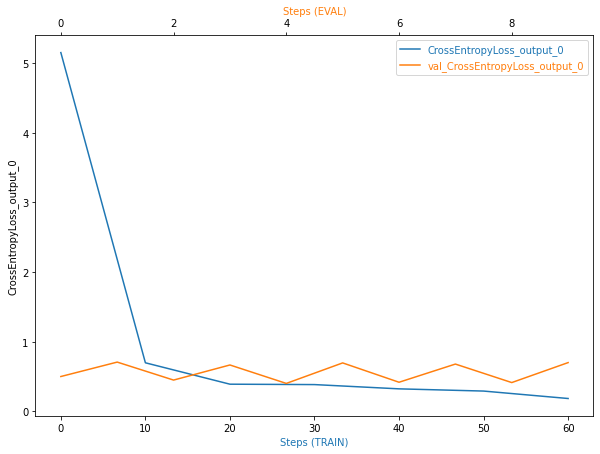

In [15]:
# Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [16]:
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2023-09-12-01-59-06-872
Region: us-east-1


In [19]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-700736504781/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-700736504781/pytorch-training-2023-09-12-01-59-06-872/profiler-output


Profiler data from system is available
[2023-09-12 02:23:51.389 pytorch-1-12-cpu-py38-ml-t3-medium-f8be1a063b37f44eb7b009d8cbea:30 INFO metrics_reader_base.py:134] Ge

In [20]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"Profiler report in {rule_output_path}")
!aws s3 cp {rule_output_path} ./ --recursive

Profiler report in s3://sagemaker-us-east-1-700736504781/pytorch-training-2023-09-12-01-59-06-872/rule-output
download: s3://sagemaker-us-east-1-700736504781/pytorch-training-2023-09-12-01-59-06-872/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-700736504781/pytorch-training-2023-09-12-01-59-06-872/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
download: s3://sagemaker-us-east-1-700736504781/pytorch-training-2023-09-12-01-59-06-872/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-700736504781/pytorch-training-2023-09-12-01-59-06-872/rule-output/ProfilerReport/profiler-output/profiler-repor

In [21]:
# Display the profiler output
import os
import IPython

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]


IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [28]:
!tar -a -cf ProfilerReport.zip ./ProfilerReport

In [46]:
import numpy as np
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [43]:
# Deploy model to an endpoint
model_location = "s3://sagemaker-us-east-1-700736504781/pytorch-training-2023-09-12-01-59-06-872/output/model.tar.gz"
pytorch_model = PyTorchModel(
    model_data=model_location, 
    role=role,
    entry_point='inference.py',
    py_version='py38',
    framework_version='1.12',
    predictor_cls=ImagePredictor
)

predictor=pytorch_model.deploy(
    initial_instance_count=1, 
    instance_type='ml.m5.large'
)

INFO:sagemaker:Creating model with name: pytorch-inference-2023-09-12-03-40-44-076
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-09-12-03-40-44-866
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-09-12-03-40-44-866


------!

In [44]:
predictor.endpoint_name

'pytorch-inference-2023-09-12-03-40-44-866'

In [47]:
image = "dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg"
with open(image, "rb") as f:
    payload = f.read()
response = predictor.predict(
    payload,
    initial_args={
        "ContentType": "image/jpeg"
    }
)
print(response)
print("Class: ", np.argmax(response, 1))

[[11.486465454101562, -18.995290756225586, -24.62748146057129, -21.29021644592285, -29.47299575805664, -20.915647506713867, -27.85683250427246, -25.49799156188965, -17.9160099029541, -27.168148040771484, -26.399459838867188, -27.4998779296875, -16.696983337402344, -26.094791412353516, -30.8416805267334, -29.608583450317383, -17.949800491333008, -25.58210563659668, -23.799171447753906, -30.34262466430664, -17.94024085998535, -24.813215255737305, -25.006593704223633, -15.541287422180176, -28.057418823242188, -14.187494277954102, -28.384361267089844, -28.409711837768555, -24.51528549194336, -13.175155639648438, -29.149335861206055, -20.403526306152344, -9.21318244934082, -19.761823654174805, -21.34584617614746, -13.37930965423584, -22.81121063232422, 4.520633220672607, -25.956077575683594, -18.848875045776367, -13.172381401062012, -0.3833116590976715, -21.777353286743164, -19.483415603637695, -23.718427658081055, -18.351673126220703, -29.475894927978516, -16.22821807861328, -13.7642564773

In [ ]:
image = "dogImages/test/021.Belgian_sheepdog/Belgian_sheepdog_01548.jpg"
with open(image, "rb") as f:
    payload = f.read()
response = predictor.predict(
    payload,
    initial_args={
        "ContentType": "image/jpeg"
    }
)
print(response)
print("Class: ", np.argmax(response, 1))

In [39]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-09-12-03-15-29-743
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-09-12-03-15-29-743
